In [1]:
import open3d as o3d
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#used to load .las data into a laspy object.
def load_laspy(las_location):
      input_las = laspy.read(las_location)
      
      return input_las

#used to return a list of unique classifications present in the input LAS file.
def get_list_classifications(input_las):
    classifications = list(set(input_las.classification))
    classifications.sort()
    
    return classifications

#Used to return a Python dictionary of laspy objects of the entire dataset as well as individual classifications.
def get_classifications_laspy(input_las):
    #get a unique list of the classifications currently contained in the dataset.
    classifications = get_list_classifications(input_las=input_las)
    #create dictionary with complete data for each province
    d = {"original_dataset": input_las}
    print("The classifications contained in this .las dataset are: ")
    print(classifications)
    print("Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.")
    for classification in classifications:
        print("Saving classification number: " +str(classification))
        classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)
        classified_points.points = input_las.points[input_las.classification == classification]
        
        d["classification_{}".format(str(classification))] = classified_points
    
    return d

#Optional function which takes the dictionary of laspy objects and converts every classification
#   into individual .LAS files 
def laspy_classifications_to_las(classifications_laspy):
    for classification_las in classifications_laspy:
        if classification_las == "original_dataset":
            pass
            print("skipped exporting the original dataset.")
        else:
            print("processing {} to a LAS file: ".format(classification_las))
            print(classifications_laspy[classification_las])
            classifications_laspy[classification_las].write("classification_{}.las".format(classification_las.split("_")[1]))
            print("done")

# Convert a .LAS file into a pandas object.
def convert_laspy_pandas(input_las):
    # Convert data into pandas DataFrame
    df = pd.DataFrame({"X":input_las.X,"Y":input_las.Y,"Z":input_las.Z,
      "x":np.array(input_las.x),"y":np.array(input_las.y),"z":np.array(input_las.z),
     'intensity': input_las.intensity,
      'classification': input_las.classification,
      'return_number': np.array(input_las.return_number),
      'number_of_returns':np.array(input_las.number_of_returns),
      'synthetic':np.array(input_las.synthetic),
      'key_point':np.array(input_las.key_point),
      'withheld':np.array(input_las.withheld),
      'overlap':np.array(input_las.overlap),
      'scanner_channel':np.array(input_las.scanner_channel),
      'scan_direction_flag':np.array(input_las.scan_direction_flag),
      'user_data':input_las.user_data,
      'scan_angle':input_las.scan_angle,
      'point_source_id':input_las.point_source_id,
      'gps_time':input_las.gps_time    
      })

    return df

# Convert a .LAS file into a pandas object.
def convert_laspy_pandas_esri(input_las):
    # Convert data into pandas DataFrame
    df = pd.DataFrame({"X":input_las.X,"Y":input_las.Y,"Z":input_las.Z,
      "x":np.array(input_las.x),"y":np.array(input_las.y),"z":np.array(input_las.z),
      'intensity': input_las.intensity,
      'return_number': np.array(input_las.return_number),
      'number_of_returns':np.array(input_las.number_of_returns),
      'scan_direction_flag':np.array(input_las.scan_direction_flag),
      'edge_of_flight_line':np.array(input_las.edge_of_flight_line),
      'classification': np.array(input_las.classification),
      'synthetic':np.array(input_las.synthetic),
      'key_point':np.array(input_las.key_point),
      'withheld':np.array(input_las.withheld),
      'scan_angle_rank':np.array(input_las.scan_angle_rank),
      'user_data':input_las.user_data,
      'point_source_id':input_las.point_source_id,
      'gps_time':input_las.gps_time,
      'red':input_las.red,
      'green':input_las.green,
      'blue':input_las.blue,    
      })

    return df

def get_selected_classes(classifications,input_las):
    classes = get_list_classifications(input_las=input_las)
    available_classes = classes
    available_classes.append(1000) #to represent the entire dataset
    class_selections = []
    current_selection = -10

    while current_selection == -10:
        print("Available classifications: " + str(available_classes))
        try:
            current_selection = input("Enter a number from the list of available classifications. To get the full dataset enter 1000 : \n")
            if current_selection.isnumeric() == False:
                print("Invalid Character Input.")
                raise ValueError()
            current_selection = int(current_selection)
            if current_selection not in available_classes:
                print("The classification number you selected: {}, is not an available class item.".format(current_selection))
                cancel = input("Would you like to exit instead? 'Y/N' ").upper() + "Y"
                if cancel[0] == "Y":
                    current_selection = -1000
                    print("Exiting and returning empty classification selection list.")
                    class_selections = []    
                else: 
                    raise ValueError()
            if (current_selection != -1000) & (current_selection != 1000):

                if 1000 in available_classes:
                    available_classes.remove(1000)
                class_selections.append(current_selection)
                print("Class {} added to dataframe.".format(str(current_selection)))
                available_classes.remove(current_selection)
                ask = input("Would you like to add another classification to the dataframe? 'Y/N' ").upper() + "Y"

                #If user prompts to add another classification, reset variable and start again.
                if ask[0] == "Y":
                    current_selection = -10
                #If user prompts to stop, exit loop and create pandas dataframe.
                else:
                    print("Classifications have been selected.")
                    class_selections.sort()

            elif current_selection == 1000:
                print("The entire dataset has been selected")
                class_selections = get_list_classifications(input_las=input_las)
                print("All classes have been added to the dataframe.")
                class_selections.sort()

        except ValueError:
            print("Please select an input from the available classification list. \n")
            current_selection = -10

    
    return class_selections

def create_combined_classifications_dataframe(class_selections,df):
    if len(class_selections) > 0:
        #initialize the dataframe with the first set of classifications
        combined_df = df.loc[df["classification"] == class_selections[0]]
        #iterate and append remaining classifications 
        for selection in class_selections[1:]:
            combined_df=pd.concat([combined_df, df.loc[df["classification"] == selection]])
    else:
        combined_df = pd.DataFrame()

    return combined_df

def create_laspy_from_dataframe(input_las,combined_df):
    classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)
    classified_points.X = combined_df["X"]
    classified_points.Y = combined_df["Y"]
    classified_points.Z = combined_df["Z"]
    classified_points.intensity = combined_df["intensity"]
    classified_points.classification = combined_df["classification"]

    return classified_points

def get_numpy_points_from_laspy_scaled(classified_points):
    point_records = classified_points.points.copy()
    # getting scaling and offset parameters
    las_scaleX = classified_points.header.scale[0]
    las_offsetX = classified_points.header.offset[0]
    las_scaleY = classified_points.header.scale[1]
    las_offsetY = classified_points.header.offset[1]
    las_scaleZ = classified_points.header.scale[2]
    las_offsetZ = classified_points.header.offset[2]
    # calculating coordinates
    p_X = np.array((point_records.X * las_scaleX) + las_offsetX) 
    p_Y = np.array((point_records.Y * las_scaleY) + las_offsetY)
    p_Z = np.array((point_records.Z * las_scaleZ) + las_offsetZ)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy


def get_numpy_points_from_laspy_unscaled(classified_points):
    point_records = classified_points.points.copy()
    # calculating coordinates
    p_X = np.array(point_records.X)
    p_Y = np.array(point_records.Y)
    p_Z = np.array(point_records.Z)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy

def get_numpy_points_from_pandas_unscaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["X"]),
                                    np.array(combined_df["Y"]),
                                    np.array(combined_df["Z"]))))

    return classified_points_numpy

def get_numpy_points_from_pandas_scaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["x"]),
                                    np.array(combined_df["y"]),
                                    np.array(combined_df["z"]))))

    return classified_points_numpy

#input numpy array to visualize using open3d
def visualize_las(classified_points,df= pd.DataFrame()):
        
    dataset = classified_points
    geom = o3d.geometry.PointCloud()
    geom.points = o3d.utility.Vector3dVector(dataset)
    #geom.colors = o3d.utility.Vector3dVector(x)
    #print(df)

    if df.empty is False:
        print("entered df")
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=df.X[0], origin=[df.X.mean(), df.Y.mean(), df.Z.mean()])
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[df.X.mean(),df.Y.mean(),df.Z.mean()])
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[0,0,0])
        o3d.visualization.draw_geometries([coord,geom])
        #o3d.visualization.draw_geometries([geom])

    else:
        o3d.visualization.draw_geometries([geom])
        print("did not enter df")
    

def multiple_classifications_to_las(classified_points,class_selections):
    ##write to a .las file
    class_selections.sort()
    sorted_classes_str = "_".join(map(str,class_selections))
    las_file_name = "classifications_" + sorted_classes_str +".las"
    classified_points.write(las_file_name)
    print("Created file: " + sorted_classes_str)




In [4]:
input_las = load_laspy(r'/Users/juancreyes/Documents/GitHub/lidar_processing/python38/Tile65_Original_Clean_Macro.las')
df = convert_laspy_pandas(input_las=input_las)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(df[["X","Y","Z"]]))
#o3d.io.write_point_cloud("./Tile65_denoisedZ.ply", pcd)
#ply_point_cloud = o3d.data.PLYPointCloud()
#pcd_2 = o3d.io.read_point_cloud("Tile65_denoisedZ.ply")
o3d.visualization.draw_geometries([pcd])

#voxelize
#downpcd_2 = pcd_2.voxel_down_sample(voxel_size=2500)
#o3d.visualization.draw_geometries([downpcd_2])

#sample down
#pcd_uni = pcd_2.uniform_down_sample(every_k_points = 10)
#o3d.visualization.draw_geometries([pcd_uni])



[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Filtering by Quarterlies Pandas

In [12]:
input_las = load_laspy(r'/Users/juancreyes/Documents/GitHub/lidar_processing/python38/Tile65_Original_Clean_Macro.las')
df = convert_laspy_pandas(input_las=input_las)
df_denoised_quarterlies_Z=df[(df["Z"] > df.Z.quantile(0.1)) & (df["Z"] < df.Z.quantile(0.90))]

df_denoised_quarterlies_Z

# Filtering by Quarterlies Laspy

In [ ]:
import laspy
import numpy as np

#input_las = load_laspy(r'/Users/juancreyes/Documents/GitHub/lidar_processing/python38/Tile65_Original_Clean_Macro.las')

percentiles = [25,50,75]

def calc_percentile(las_path,percentiles = percentiles):
    #Load the .LAS file
    input_las = laspy.read(las_path)
    #Compute the x, y, and z quartiles.

    x_quarter = np.percentile(input_las.x,percentiles)
    
    


In [19]:
import laspy
import numpy as np

def filter_point_cloud(las_path, output_path, quarter_size=1000):
    # Load the LAS file
    las = laspy.read(las_path)

    # Compute the x, y, and z quartiles
    x_quarter = np.percentile(las.x, [25, 50, 75])
    y_quarter = np.percentile(las.y, [25, 50, 75])
    z_quarter = np.percentile(las.z, [25, 50, 75])

    # Filter out points outside the inner quartile range
    x_mask = np.logical_and(las.x >= x_quarter[0] - quarter_size, las.x <= x_quarter[2] + quarter_size)
    y_mask = np.logical_and(las.y >= y_quarter[0] - quarter_size, las.y <= y_quarter[2] + quarter_size)
    z_mask = np.logical_and(las.z >= z_quarter[0] - quarter_size, las.z <= z_quarter[2] + quarter_size)
    mask = np.logical_and(np.logical_and(x_mask, y_mask), z_mask)
    las_filtered = las[mask]

    # Write the filtered point cloud to a new LAS file
    las_filtered.write(output_path)


In [13]:
import os

input_dir = "/path/to/input/directory"
output_dir = "/path/to/output/directory"

for filename in os.listdir(input_dir):
    if filename.endswith(".las"):
        las_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        filter_point_cloud(las_path, output_path)


,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
0,290988240,-186802461,-278,290988.240,4813197.539,-0.278,2474,9,1,1,0,0,0,0,0,1,1,-1685,2610,135243.776060
3,290987251,-186802246,-286,290987.251,4813197.754,-0.286,16268,9,1,1,0,0,0,0,0,1,1,-1662,2610,135243.776078
4,290987142,-186802229,-314,290987.142,4813197.771,-0.314,2284,9,1,1,0,0,0,0,0,1,1,-1659,2610,135243.776080
5,290987031,-186802200,-294,290987.031,4813197.800,-0.294,3498,9,1,1,0,0,0,0,0,1,1,-1657,2610,135243.776082
6,290986811,-186802148,-285,290986.811,4813197.852,-0.285,9661,9,1,1,0,0,0,0,0,1,1,-1652,2610,135243.776086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475668,291021707,-186959003,-5988,291021.707,4813040.997,-5.988,8006,40,4,4,0,0,0,0,0,0,4,2608,2812,135839.339792
1475669,291023077,-186958983,-6106,291023.077,4813041.017,-6.106,9006,40,3,3,0,0,0,0,0,0,4,2583,2812,135839.339821
1475670,291024487,-186959065,-5844,291024.487,4813040.935,-5.844,1111,0,2,3,0,0,0,0,0,0,4,2558,2812,135839.339849
1475671,291024446,-186958966,-6269,291024.446,4813041.034,-6.269,12767,40,3,3,0,0,0,0,0,0,4,2558,2812,135839.339849


# Box plots per classification

<AxesSubplot: title={'center': 'Z'}, xlabel='classification'>

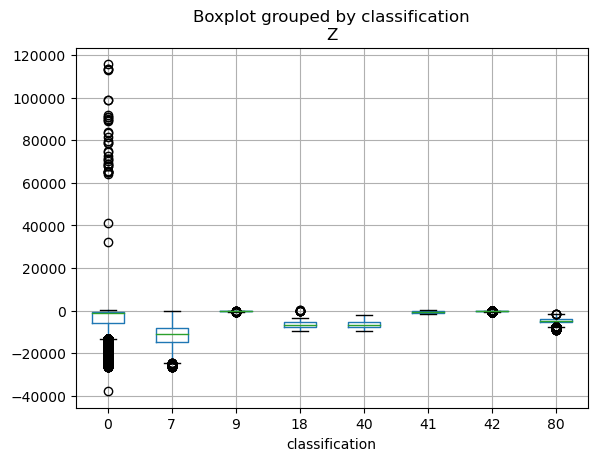

In [4]:
df.boxplot(column='Z', by='classification')


In [5]:
print("Min Z value: ", df.Z.min())

print("InterQuartile R1: ", df.Z.quantile(0.10))
print("InterQuartile R2: ", df.Z.quantile(0.90))

print("Max Z value: ", df.Z.max())

Min Z value:  -37933
InterQuartile R1:  -8076.0
InterQuartile R2:  -274.0
Max Z value:  115792


Creating .PLY point clouds

In [6]:
#df_denoised_quarterlies_Z=df[(df["Z"] < df.Z.quantile(0.10)) | (df["Z"] > df.Z.quantile(0.95))]
#df_denoised_quarterlies_Z=df[(df["Z"] > df.Z.quantile(0.1)) & (df["Z"] < df.Z.quantile(0.90))]
df_denoised_quarterlies_Z=df[(df["Z"] > df[df.classification == 40].Z.min()) & (df["Z"] < df.Z.quantile(0.90))]
pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(np.array(df_denoised_quarterlies_Z[["X","Y","Z"]]))
#o3d.io.write_point_cloud("./Tile65_denoisedZ.ply", pcd)


#ply_point_cloud = o3d.data.PLYPointCloud()
#pcd_2 = o3d.io.read_point_cloud("Tile65_denoisedZ.ply")
o3d.visualization.draw_geometries([pcd])

#voxelize
#downpcd_2 = pcd_2.voxel_down_sample(voxel_size=2500)
#o3d.visualization.draw_geometries([downpcd_2])

#sample down
#pcd_uni = pcd_2.uniform_down_sample(every_k_points = 10)
#o3d.visualization.draw_geometries([pcd_uni])



: 

: 

For specific classifications

In [102]:
water_surface = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 41) | (df_denoised_quarterlies_Z["classification"] == 42)]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(water_surface[["X","Y","Z"]]))
o3d.io.write_point_cloud("./Tile65_denoisedZ_41_42.ply", pcd)
pcd_3 = o3d.io.read_point_cloud("./Tile65_denoisedZ_41_42.ply")

pcd_3.paint_uniform_color([1,0,0])

o3d.visualization.draw_geometries([pcd_3])





[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [146]:
pcd_full = o3d.geometry.PointCloud()
pcd_full.points = o3d.utility.Vector3dVector(np.array(df[["X","Y","Z"]]))

print("The length of the original dataframe", len(df))
#df_denoised_quarterlies_Z=df[(df["Z"] > df.Z.quantile(0.10)) & (df["Z"] < df.Z.quantile(0.90))]
df_denoised_quarterlies_Z=df[(df["Z"] > df[df.classification == 40].Z.min()) & (df["Z"] < df.Z.quantile(0.90))]
#df_denoised_quarterlies_Z=df
print("The length of the new dataframe: ",len(df_denoised_quarterlies_Z))
pcd_denoised_quarterlies_z = o3d.geometry.PointCloud()
pcd_denoised_quarterlies_z.points = o3d.utility.Vector3dVector(np.array(df_denoised_quarterlies_Z[["X","Y","Z"]]))

#o3d.io.write_point_cloud("./Tile65_denoisedZ.ply", pcd_denoised_quarterlies_z)
#pcd_3 = o3d.io.read_point_cloud("./Tile65_denoisedZ.ply")


bathymetry = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 40)]
pcd_bathy = o3d.geometry.PointCloud()
pcd_bathy.points = o3d.utility.Vector3dVector(np.array(bathymetry[["X","Y","Z"]]))
pcd_bathy.paint_uniform_color([0,0,0])


water_normal = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 41)]
pcd_water_normal = o3d.geometry.PointCloud()
pcd_water_normal.points = o3d.utility.Vector3dVector(np.array(water_normal[["X","Y","Z"]]))
pcd_water_normal.paint_uniform_color([1,0,0])


water_synthetic = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 42)]
pcd_water_synthetic = o3d.geometry.PointCloud()
pcd_water_synthetic.points = o3d.utility.Vector3dVector(np.array(water_synthetic[["X","Y","Z"]]))
pcd_water_synthetic.paint_uniform_color([0,1,0])


#o3d.visualization.draw_geometries([pcd_bathy,pcd_water_normal,pcd_water_synthetic])
#o3d.visualization.draw_geometries([pcd_full,pcd_bathy])
o3d.visualization.draw_geometries([pcd_water_synthetic])


The length of the original dataframe 1475679
The length of the new dataframe:  1281727
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


<AxesSubplot: title={'center': 'Z'}, xlabel='classification'>

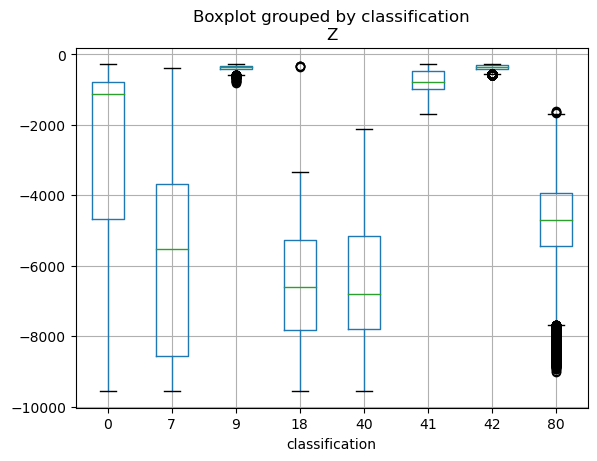

In [145]:
df_denoised_quarterlies_Z.boxplot(column='Z', by='classification')


In [187]:
water_normal = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 41)]
pcd_water_normal = o3d.geometry.PointCloud()
pcd_water_normal.points = o3d.utility.Vector3dVector(np.array(water_normal[["X","Y","Z"]]))
pcd_water_normal.paint_uniform_color([1,0,0])

abb = pcd_water_normal.get_axis_aligned_bounding_box()
abb.color = (1,0,0)

obb = pcd_water_normal.get_oriented_bounding_box()
obb.color = (0,0,0)

#voxelize
water_normal_voxels = pcd_water_normal.voxel_down_sample(voxel_size=2000)

#pcl = o3dtut.get_bunny_mesh().sample_points_poisson_disk(number_of_points=2000)
ch, _ = water_normal_voxels.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(ch)
hull_ls.paint_uniform_color((1, 0, 1))
o3d.visualization.draw_geometries([water_normal_voxels, hull_ls,abb,ch,obb])



#o3d.visualization.draw_geometries([water_normal_voxels,abb])

#sample down
#water_synth_uni = pcd_water_synthetic.uniform_down_sample(every_k_points = 100)
#abb = water_synth_uni.get_axis_aligned_bounding_box()
#abb.color = (1,0,0)
#o3d.visualization.draw_geometries([water_synth_uni,abb])



#o3d.visualization.draw_geometries([pcd_bathy,pcd_water_normal,pcd_water_synthetic])
#o3d.visualization.draw_geometries([pcd_full,pcd_bathy])
#o3d.visualization.draw_geometries([pcd_water_synthetic,pcd_water_normal,abb,obb])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [186]:
water_synthetic = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 42)]
pcd_water_synthetic = o3d.geometry.PointCloud()
pcd_water_synthetic.points = o3d.utility.Vector3dVector(np.array(water_synthetic[["X","Y","Z"]]))
pcd_water_synthetic.paint_uniform_color([0,1,0])

abb = pcd_water_synthetic.get_axis_aligned_bounding_box()
abb.color = (1,0,0)

obb = pcd_water_synthetic.get_oriented_bounding_box()
obb.color = (0,0,0)

#voxelize
water_synth_voxels = pcd_water_synthetic.voxel_down_sample(voxel_size=2000)
o3d.visualization.draw_geometries([water_synth_voxels,abb,obb])

#sample down
#water_synth_uni = pcd_water_synthetic.uniform_down_sample(every_k_points = 100)
#abb = water_synth_uni.get_axis_aligned_bounding_box()
#abb.color = (1,0,0)
#o3d.visualization.draw_geometries([water_synth_uni,abb])



#o3d.visualization.draw_geometries([pcd_bathy,pcd_water_normal,pcd_water_synthetic])
#o3d.visualization.draw_geometries([pcd_full,pcd_bathy])
#o3d.visualization.draw_geometries([pcd_water_synthetic,pcd_water_normal,abb,obb])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


DBSCAN clustering original water

In [205]:
water_normal = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 41)]
pcd_water_normal = o3d.geometry.PointCloud()
pcd_water_normal.points = o3d.utility.Vector3dVector(np.array(water_normal[["X","Y","Z"]]))
#pcd_water_normal.paint_uniform_color([1,0,0])
abb = pcd_water_normal.get_axis_aligned_bounding_box()
abb.color = (1,0,0)
obb = pcd_water_normal.get_oriented_bounding_box()
obb.color = (0,0,0)

#voxelize
#water_normal_voxels = pcd_water_normal.voxel_down_sample(voxel_size=2000)

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd_water_normal.cluster_dbscan(eps=1000, min_points=5, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_water_normal.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd_water_normal])
                                  
                                  

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 2                       ] 2%
Precompute neighbors.[================>           point cloud has 2 clusters
Precompute neighbors.[========================================] 100%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


DBSCAN water surface

In [210]:
water_surface = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 41) | (df_denoised_quarterlies_Z["classification"] == 42)]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(water_surface[["X","Y","Z"]]))
#o3d.io.write_point_cloud("./Tile65_denoisedZ_41_42.ply", pcd)
#pcd_3 = o3d.io.read_point_cloud("./Tile65_denoisedZ_41_42.ply")
#pcd_3.paint_uniform_color([1,0,0])

abb = pcd.get_axis_aligned_bounding_box()
abb.color = (1,0,0)
obb = pcd.get_oriented_bounding_box()
obb.color = (0,0,0)


with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=500, min_points=2, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])






[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
Precompute neighbors.[================>                       ] 37%                                     ] 5%
Precompute neighbors.[========================================] 100%
point cloud has 3112 clusters=====================>] 97%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


DBSCAN bathy & water surface

In [219]:
water_bathy = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 41) | (df_denoised_quarterlies_Z["classification"] == 42) | (df_denoised_quarterlies_Z["classification"] == 40) ]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(water_bathy[["X","Y","Z"]]))
#o3d.io.write_point_cloud("./Tile65_denoisedZ_41_42.ply", pcd)
#pcd_3 = o3d.io.read_point_cloud("./Tile65_denoisedZ_41_42.ply")
#pcd_3.paint_uniform_color([1,0,0])

abb = pcd.get_axis_aligned_bounding_box()
abb.color = (1,0,0)
obb = pcd.get_oriented_bounding_box()
obb.color = (0,0,0)

water_bathy_voxels = pcd.voxel_down_sample(voxel_size=2000)


with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        water_bathy_voxels.cluster_dbscan(eps=2350, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
water_bathy_voxels.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([water_bathy_voxels])






[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 148
point cloud has 148 clusters
Precompute neighbors.[========================================] 100%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


DBSCAN on denoised dataset.

In [237]:
#df_denoised_quarterlies_Z=df[(df["Z"] > df.Z.quantile(0.10)) & (df["Z"] < df.Z.quantile(0.90))]
df_denoised_quarterlies_Z=df[(df["Z"] > df[df.classification == 40].Z.min()) & (df["Z"] < df.Z.quantile(0.90))]
#df_denoised_quarterlies_Z=df
print("The length of the new dataframe: ",len(df_denoised_quarterlies_Z))
pcd_denoised_quarterlies_z = o3d.geometry.PointCloud()
pcd_denoised_quarterlies_z.points = o3d.utility.Vector3dVector(np.array(df_denoised_quarterlies_Z[["X","Y","Z"]]))

abb = pcd_denoised_quarterlies_z.get_axis_aligned_bounding_box()
abb.color = (1,0,0)
obb = pcd_denoised_quarterlies_z.get_oriented_bounding_box()
obb.color = (0,0,0)

denoised_voxels = pcd_denoised_quarterlies_z.voxel_down_sample(voxel_size=2000)


with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        denoised_voxels.cluster_dbscan(eps=2250, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
denoised_voxels.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([denoised_voxels])




The length of the new dataframe:  1281727
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.                     ] 2%
[Open3D DEBUG] Compute Clusters
Precompute neighbors.[================>           [Open3D DEBUG] Done Compute Clusters: 386
Precompute neighbors.[========point cloud has 386 clusters    ] 75%
Precompute neighbors.[========================================] 100%
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Plane Segmentation

water surface

In [263]:
water_surface = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 41) | (df_denoised_quarterlies_Z["classification"] == 42)]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(water_surface[["X","Y","Z"]]))
#o3d.io.write_point_cloud("./Tile65_denoisedZ_41_42.ply", pcd)
#pcd_3 = o3d.io.read_point_cloud("./Tile65_denoisedZ_41_42.ply")
#pcd_3.paint_uniform_color([1,0,0])

abb = pcd.get_axis_aligned_bounding_box()
abb.color = (1,0,0)
obb = pcd.get_oriented_bounding_box()
obb.color = (0,0,0)

denoised_voxels = pcd.voxel_down_sample(voxel_size=1000)


plane_model, inliers = denoised_voxels.segment_plane(distance_threshold=10,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = denoised_voxels.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = denoised_voxels.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])


#o3d.visualization.draw_geometries([denoised_voxels])






Plane equation: -0.00x + -0.00y + 1.00z + 194869.90 = 0
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Plane segmentation bathymetry:

In [286]:
bathymetry = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 40)]
pcd_bathy = o3d.geometry.PointCloud()
pcd_bathy.points = o3d.utility.Vector3dVector(np.array(bathymetry[["X","Y","Z"]]))

abb = pcd_bathy.get_axis_aligned_bounding_box()
abb.color = (1,0,0)
obb = pcd_bathy.get_oriented_bounding_box()
obb.color = (0,0,0)




denoised_voxels = pcd_bathy.voxel_down_sample(voxel_size=1000)


plane_model, inliers = denoised_voxels.segment_plane(distance_threshold=800,
                                         ransac_n=40,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = denoised_voxels.select_by_index(inliers)
inlier_cloud.paint_uniform_color([0.0, 0, 0])
outlier_cloud = denoised_voxels.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud,abb,obb])








Plane equation: 0.04x + 0.00y + 1.00z + -10906293.21 = 0
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Normal Data

In [281]:
print("Recompute the normal of the downsampled point cloud")
denoised_voxels.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=10, max_nn=30))
o3d.visualization.draw_geometries([denoised_voxels],                                
                                  point_show_normal=True)

Recompute the normal of the downsampled point cloud
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [285]:
print("Print a normal vector of the 0th point")
print(denoised_voxels.normals[0])

Print a normal vector of the 0th point
[0. 0. 1.]


Make a mesh:

In [297]:
import open3d as o3d
import numpy as np


bathymetry = df_denoised_quarterlies_Z[(df_denoised_quarterlies_Z["classification"] == 40)]
pcd_bathy = o3d.geometry.PointCloud()
pcd_bathy.points = o3d.utility.Vector3dVector(np.array(bathymetry[["X","Y","Z"]]))

abb = pcd_bathy.get_axis_aligned_bounding_box()
abb.color = (1,0,0)
obb = pcd_bathy.get_oriented_bounding_box()
obb.color = (0,0,0)

#denoised_voxels = pcd_bathy.voxel_down_sample(voxel_size=2000)

# Create a mesh from the point cloud
alpha = 10000000  # alpha value for the alpha shape algorithm
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    pcd_bathy, alpha)

# Visualize the mesh
o3d.visualization.draw_geometries([mesh])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


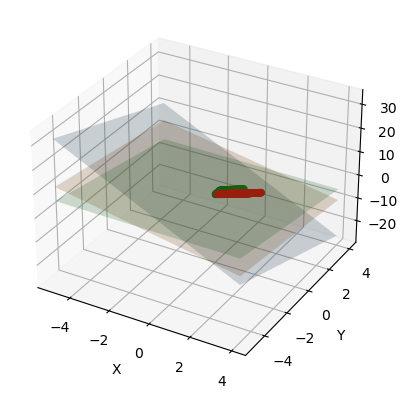

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random vectors
v1 = np.random.rand(3)
v2 = np.random.rand(3)
v3 = np.random.rand(3)

# Make sure the vectors are linearly independent
while np.abs(np.linalg.det(np.vstack((v1,v2,v3)))) < 1e-6:
    v1 = np.random.rand(3)
    v2 = np.random.rand(3)
    v3 = np.random.rand(3)

# Generate points on each plane
n_points = 1000
plane1_points = np.zeros((n_points, 3))
plane2_points = np.zeros((n_points, 3))
plane3_points = np.zeros((n_points, 3))

for i in range(n_points):
    r1, r2 = np.random.rand(2)
    plane1_points[i] = r1*v1 + r2*v2
    
    r1, r2 = np.random.rand(2)
    plane2_points[i] = r1*v2 + r2*v3
    
    r1, r2 = np.random.rand(2)
    plane3_points[i] = r1*v3 + r2*v1

# Visualize the planes and points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the planes
xx, yy = np.meshgrid(range(-5, 5), range(-5, 5))
z1 = (-v1[0]*xx - v1[1]*yy) / v1[2]
ax.plot_surface(xx, yy, z1, alpha=0.2)
z2 = (-v2[0]*xx - v2[1]*yy) / v2[2]
ax.plot_surface(xx, yy, z2, alpha=0.2)
z3 = (-v3[0]*xx - v3[1]*yy) / v3[2]
ax.plot_surface(xx, yy, z3, alpha=0.2)

# Plot the points
ax.scatter(plane1_points[:,0], plane1_points[:,1], plane1_points[:,2], c='r')
ax.scatter(plane2_points[:,0], plane2_points[:,1], plane2_points[:,2], c='g')
ax.scatter(plane3_points[:,0], plane3_points[:,1], plane3_points[:,2], c='b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()